# Exploration initiale

> Ce notebook contient quelques pistes pour explorer les données sur les tweets. Pour éviter tout problème, nous avons fait le choix d'anonymiser les ids des tweets et des utilisateurs et de décorréler les informations sur les retweets. De plus, les dates ont été légérement modifiées.
> 
> Les données texte sont contenues dans le fichier `text_data.csv` et les données de retweets sont stockées dans le fichier `graph_data.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json

## Lecture des données texte

In [2]:
df_text = pd.read_csv('text_data.csv')
df_text.head()

,user_id_str,timestamp_ms,text
0,-8790648164648501458,1.643323e+12,RT @YvesPDB: La fragilité des young leaders de...
1,3038431102003874432,1.643324e+12,RT @Mike_Bresson: Le chômage au plus bas depui...
2,-3957050983149290591,1.643357e+12,RT @Sergi_lub: Je vais partager mon témoignage...
3,6457802829221855681,1.643329e+12,RT @BOROWSKIMIKE: Macron qui a fermé plus de 1...
4,-6548238077394744598,1.643357e+12,RT @founzydelamoya: Pensez vous que macron soi...


In [3]:
print('nb de tweets: ', len(df_text))
print('nb utilisateurs: ', df_text['user_id_str'].nunique())

nb de tweets:  25812
nb utilisateurs:  16872


## Étude temporelle

In [4]:
df_text['datetime'] = pd.to_datetime(df_text['timestamp_ms'], unit='ms')

df_text['datetime'].min(), df_text['datetime'].max()

(Timestamp('2022-01-27 21:48:05.610406006'),
 Timestamp('2022-01-28 17:30:37.092871826'))

> Pour calculer le nombre de tweets par minutes, nous allons extraire les ans, mois, jours, heures, minutes de nos données puis reconstruire une colonne `datetime` à partir de ces données. On pourra ainsi aggréger les données selon cette colonne: 

In [5]:
time_analysis = df_text[['datetime']].copy()

time_analysis['nb_tweets'] = 1

time_analysis['year'] = time_analysis['datetime'].dt.year
time_analysis['month'] = time_analysis['datetime'].dt.month
time_analysis['day'] = time_analysis['datetime'].dt.day

time_analysis['hour'] = time_analysis['datetime'].dt.hour
time_analysis['minute'] = time_analysis['datetime'].dt.minute

time_analysis = time_analysis.groupby(['year', 'month', 'day', 'hour', 'minute']).sum().reset_index()

time_analysis['datetime'] = pd.to_datetime(time_analysis[['year', 'month', 'day', 'hour', 'minute']])

time_analysis.head()

,year,month,day,hour,minute,nb_tweets,datetime
0,2022,1,27,21,48,14,2022-01-27 21:48:00
1,2022,1,27,21,54,8,2022-01-27 21:54:00
2,2022,1,27,21,55,105,2022-01-27 21:55:00
3,2022,1,27,21,56,116,2022-01-27 21:56:00
4,2022,1,27,21,57,108,2022-01-27 21:57:00


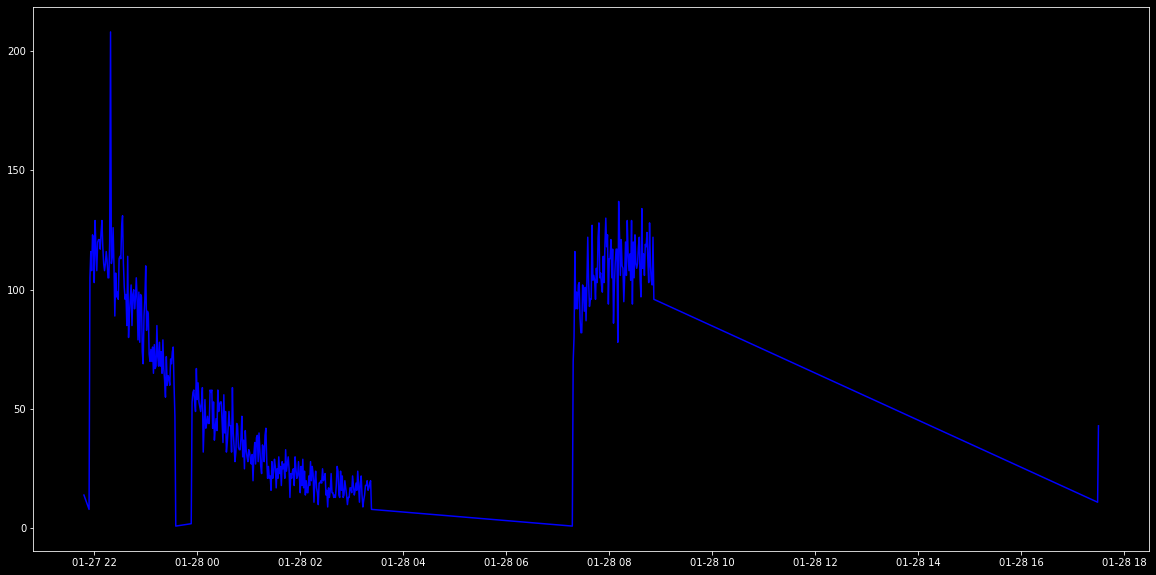

In [6]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 10))
    plt.plot(time_analysis['datetime'], time_analysis['nb_tweets'], color='b')
    plt.show()

> Sur ce graphique, on voit bien les moments où le programme permettant de récupérer les données était en fonctionnement. Si on s'intéresse à la première partie, entre le 27 et le 28 à 4h: 

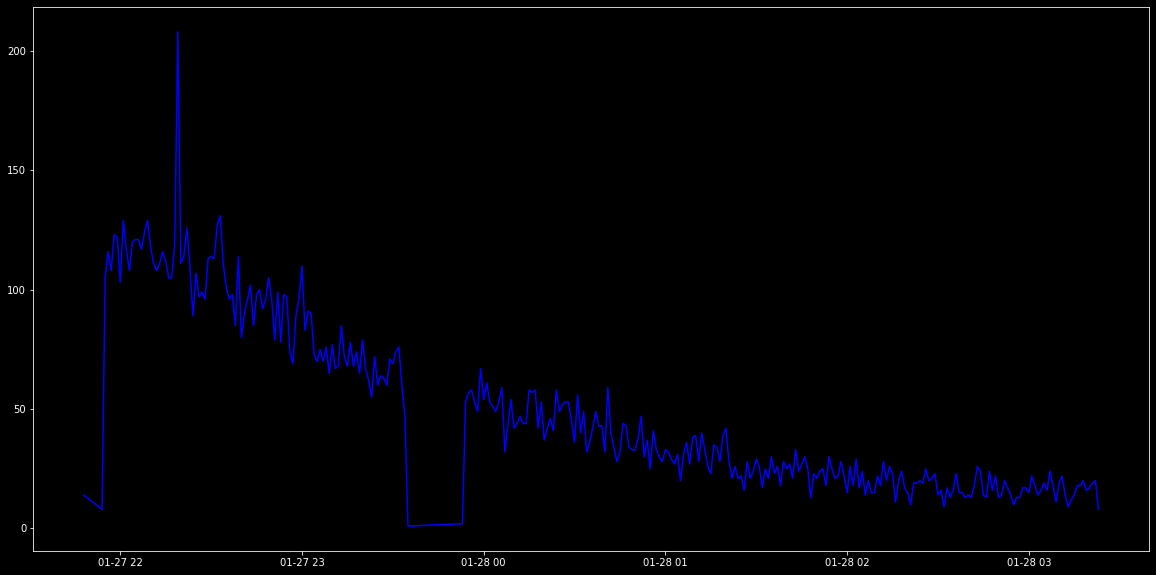

In [7]:
time_limit = pd.to_datetime('28/01/2022 4:00:00')

with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 10))
    plt.plot(
        time_analysis['datetime'][time_analysis['datetime'] < time_limit],
        time_analysis['nb_tweets'][time_analysis['datetime'] < time_limit], color='b')
    plt.show()


> On peut voir une décroissance du nombre de tweets assez naturelle au vu de l'heure et du sujet (Macron). 

## Étude des utilisateurs

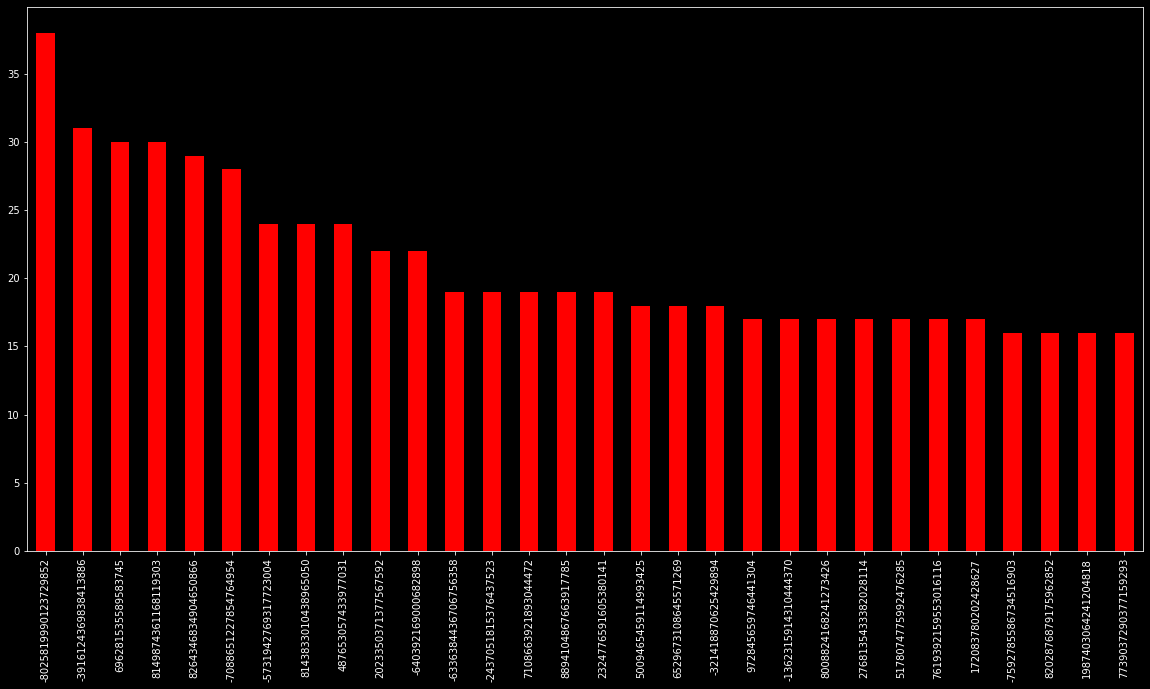

In [8]:
with plt.style.context('dark_background'):

    df_text['user_id_str'].value_counts().head(30).plot.bar(figsize=(20, 10), color='r')
    plt.show()


> Un des utilisateurs semblent avoir plus de 35 tweets sur cette période:

In [9]:
top_user = df_text['user_id_str'].value_counts().index[0]
print(top_user)

top_user_tweets = df_text.loc[df_text['user_id_str'] == top_user, 'text']
top_user_tweets

-8025819990123729852


175      RT @KiriJeankiri: #OlivierVeran qui se saisit ...
953      RT @BOROWSKIMIKE: Macron est-il sous l’influen...
1501     RT @Independenzia64: Respect au #Canada, ils s...
2077     RT @flamecapitain: #Trudeau #macron #Ottawa #P...
2847     RT @JeanRobinMedia: Pour trouver des qualités ...
5905     RT @ChandelonR: Macron avait augmenté la CSG p...
6056     RT @Independenzia64: Respect au #Canada, ils s...
6426     RT @jayjay11800: #blanquer #veran #passvaccinn...
6854     RT @graphAD: #Trudeau et #macron, même combat,...
7355     RT @Ari268748566: Macron a détruit la France :...
7451     RT @Independenzia64: Respect au #Canada, ils s...
7905     RT @dee_agnesdday: Si seulement les Canadiens ...
8679     RT @lorie_laurette: On comprend mieux la fuite...
9007     RT @dee_agnesdday: Si seulement les Canadiens ...
9475     RT @dee_agnesdday: Si seulement les Canadiens ...
9791     RT @marc_ottin: #Trudeau s’est mis à l’abri en...
11396    RT @dee_agnesdday: Si seulement les Canadiens .

> On a l'impression que ce ne sont que des retweets. On peut regarder le nombre de tweets différents.


In [10]:
unique_tweets_nb = len(top_user_tweets.drop_duplicates())
print('nb of unique tweets:', unique_tweets_nb)
print('percentage:', round(unique_tweets_nb/len(top_user_tweets) * 100, 2))


nb of unique tweets: 26
percentage: 68.42


> On peut aussi regarder la distribution du nombre de tweets par utilisateurs:

In [11]:
df_text['user_id_str'].value_counts().describe([i/10 for i in range(10)])

count    16872.000000
mean         1.529872
std          1.551536
min          1.000000
0%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          2.000000
90%          3.000000
max         38.000000
Name: user_id_str, dtype: float64

> Sans grande surprise, plus de 70% de utilisateurs n'ont tweeté qu'une seule fois. Étudions la distribution pour les autres utilisateurs:

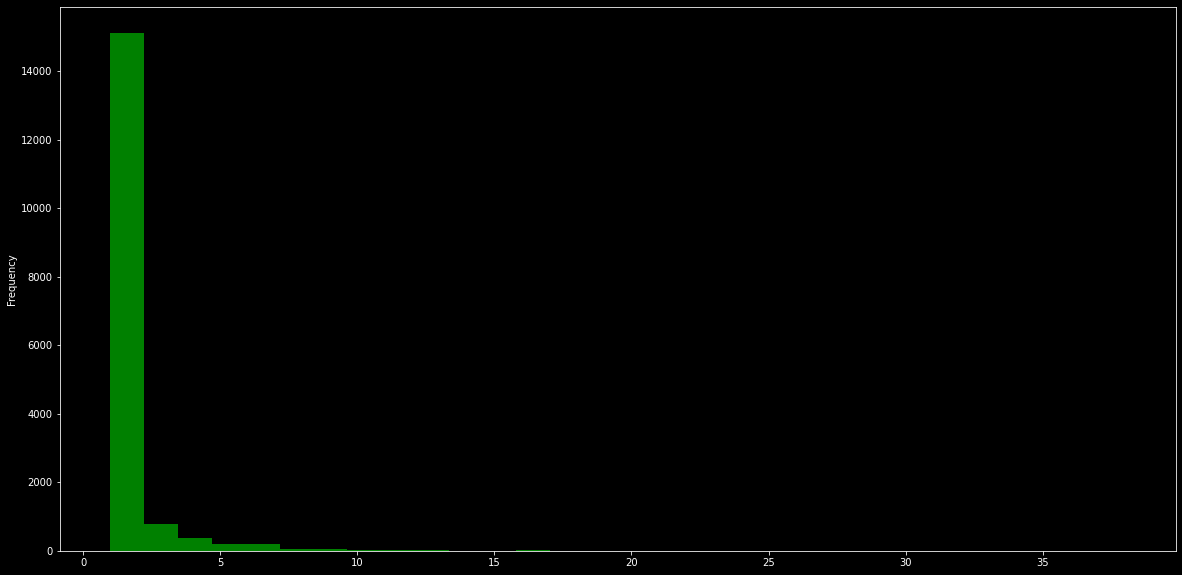

In [12]:
with plt.style.context('dark_background'):

    df_text['user_id_str'].value_counts().plot.hist(figsize=(20, 10), color='g', bins=30)
    plt.show()

## Quelques idées pour poursuivre l'analyse


> - évaluer la contribution des personnes ayant tweeté plusieurs fois au nombre total de tweets
